In [203]:
import numpy as np
import matplotlib.pyplot as plt

Resources
libs/diff-gaussian-rasterization-confidence/cuda_rasterizer
libs/diff-gaussian-rasterization-confidence/cuda_rasterizer/forward.cu
libs/diff-gaussian-rasterization-confidence/cuda_rasterizer/auxiliary.h
4D-Rotor-Gaussians/nerfstudio/utils/sh_utils.py

In [204]:
# Camera view
# https://twodee.org/blog/17560
def get_up_normal_vec(lookat,theta): 
    """This function will allways return the up vector 
    which is perpenticular to lookup and make a theta angle clockwise with the plane
    common to the lookup and k vectors
    returns up unit vector - (a,b,c)"""
    k = np.array([0,0,1])
    if lookat[0]==0 and lookat[1]==0:
        w = np.array([0,1,0])   # if look at is in an direction of z, start up as the original y
        n = np.cross(lookat,w) 
    else:
        n = np.cross(lookat,k) 
        n = n/np.linalg.norm(n)
        w = np.cross(n,lookat)
        w = w/np.linalg.norm(w)
    up = np.cos(theta)*w + np.sin(theta)*n
    return up

def get_viewmatrix(pos,lookat,up):
    """Here both lookat and up vectors are assumed as unit vectors"""
    vec_2 = lookat                  # Forward
    vec_0 = np.cross(up,lookat)     # Right
    vec_1 = np.cross(vec_2,vec_0)   # To ensuare the orthogonality
    vec_0, vec_1, vec_2 = np.expand_dims(vec_0,axis=0),np.expand_dims(vec_1,axis=0), np.expand_dims(vec_2,axis=0)
    print(f"vec_o= {vec_0}, vec_1(up)={vec_1}, vec_2(lookat)={vec_2}")
    m = np.concatenate((vec_0,vec_1,vec_2),axis=0)
    pos_ = np.reshape(np.array([-np.dot(pos,vec) for vec in m]),(3,1)) #np.reshape(pos,(3,1)) # Expandind dimensions and making a column matrix
    m = np.concatenate((m,pos_),axis=1)
    view_mat= np.concatenate((m,np.array([[0,0,0,1]])),axis=0)
    return view_mat

def get_projection_matrix(z_near, z_far, tan_fovx, tan_fovy):
    r = z_near*tan_fovx
    l = -r
    t = z_near*tan_fovy
    b = -t
    # projection matrix in row major way
    p = np.array([[2*z_near/(r-l), 0, (r+l)/(r-l), 0],
                  [0, 2*z_near/(t-b), (t+b)/(t-b), 0],
                  [0, 0, -(z_far+z_near)/(z_far-z_near), -2*z_near*z_far/(z_far-z_near)],   # This is OpenGL style.  [0.0, 0.0, f / (f - n), -n * f / (f - n)] is the directX style (used in the code).
                  [0, 0, -1, 0]])
    """
    Note:
    After applying the projection, we need to perform the perspective divide. (divide by w-component)
    """
    return p

In [205]:
def compute_color_from_sh(deg, lookat, sh, Coffs):
    x=lookat[0]
    y=lookat[1]
    z=lookat[2]
    C0 = Coffs["C0"]    # Float
    C1 = Coffs["C1"]    # Float
    C2 = Coffs["C2"]    # List
    result = C0*sh[0]
    if deg>0:
        result = result - C1*y*sh[1] + C1*z*sh[2] - C1*x*sh[3]
    if deg>1:
        xx, yy, zz = x*x, y*y, z*z
        xy, yz, xz = x*y, y*z, x*z
        result = result +\
				C2[0] * xy * sh[4] +\
				C2[1] * yz * sh[5] +\
				C2[2] * (2 * zz - xx - yy) * sh[6] +\
				C2[3] * xz * sh[7] +\
				C2[4] * (xx - yy) * sh[8]
    #if deg>2:
    result+=0.5
    # Store the normalized RGB values
    # Clamped if values less than 0 or 1
    result[0] = max(0,min(1,result[0]))
    result[1] = max(0,min(1,result[1]))
    result[2] = max(0,min(1,result[2]))
    return result

def get_3d_cov_mat(scal,quat, mod):
    scale_mat = np.zeros((3,3))
    for i in range(3):
        scale_mat[i][i] =scal[i]*mod
    r,x,y,z = quat[0],quat[1],quat[2],quat[3]
    rot_mat = np.array([[1-2*(y**2+z**2), 2*(x*y-r*z), 2*(x*z+r*y)],
                        [2*(x*y+r*z), 1-2*(x**2+z**2), 2*(y*z-r*x)],
                        [2*(x*z-r*y),2*(y*z+r*x), 1-2*(x**2+y**2)]])
    """M = np.matmul(scale_mat,rot_mat)
    Sigma = np.matmul(M.T,M)""" # What they have done in the code in forward.cu
    M = np.matmul(rot_mat,scale_mat)
    Sigma = np.matmul(M,M.T)    # In the paper
    # In the cuda code they have only stored the upper right part, since this matrix is symmetric
    print(f"Rot_mat \n {rot_mat}")
    print(f"scale_mat \n {scale_mat}")
    print(f"Sigma (Cov3D) \n {Sigma}")
    return Sigma

# Additional function for calculate cov_3D in camera perspective
def get_cam_cov_3D(viewmatrix, cov_3D):
    w = viewmatrix[0:3,0:3]
    cov_3D_cam = np.matmul(np.matmul(w,cov_3D),w.T)
    return cov_3D_cam


def get_2d_cov_mat(viewmatrix, mean, focal_x, focal_y, tan_fovx, tan_fovy, cov_3D):
    mean = np.concatenate((np.reshape(mean,(3,1)),np.array([[1]])),axis=0)
    new_mean = np.reshape(np.matmul(viewmatrix,mean),(4))[0:3]
    x,y,z = new_mean[0], new_mean[1], new_mean[2]
    limx = 1.3*tan_fovx
    limy = 1.3*tan_fovy
    txtz = x/z
    tytz = y/z
    x = min(limx,max(-limx,txtz))*z
    y = min(limy,max(-limy,tytz))*z
    jacob_mat = np.array([[focal_x/z,0,-(focal_x*x/(z**2))],
                          [0,focal_y/z,-(focal_y*y/(z**2))],
                          [0,0,0]])
    w = viewmatrix[0:3,0:3]
    """ In the code they hve use T=w*j
    cov = transpose(T)*cov_3d*T 
    But is theory, Cov_2d = J*W*covg_3d*W.T*J.T 
    """
    JW = np.matmul(jacob_mat,w)
    cov_2D = np.matmul(np.matmul(JW,cov_3D),JW.T)
    # Every pixel should be 1 pixel wide and high. Discard the 3rd row and col
    cov_2D[0][0]+= 0.3
    cov_2D[1][1]+= 0.3
    cov_2D = cov_2D[0:2,0:2]
    print(f"cov_2D \n {cov_2D}")
    return cov_2D

def in_frustum(mean_2d_normal, mean_wrt_camera_3d):
    x=mean_2d_normal[0]
    y=mean_2d_normal[1]
    print(f"x {x}")
    print(f"y {y}")
    print(f"mean_wrt_camera_3d[2] = {mean_wrt_camera_3d[2]}")
    if (mean_wrt_camera_3d[2]<= 0.2) or (x<-1.3 or x>1.3 or y<-1.3 or y>1.3) :
        print(f"Point is out of the frustrum")
        return False
    return True

def ndc2pix(v,s):   # v: value in the rang(-1,1). s: pixels in the dimension
    return ((v+1)*s-1)/2    # Returns a float value for pixel value ex:-(15.0 or 15.5)

def pix2ndc(p,s):
    return (2*p+1)/s-1

In [206]:
# Pre processing

def pre_process(num_gaussians, means, quat_s, scale_vals, scale_modifiers,
                grid, block_len, img_width, img_height,
                lookat, focal_x, focal_y, tan_fovx, tan_fovy, 
                view_mat, project_mat, 
                shs, Coffs, degrees_of_gaussians,
                radii, tiles_touched, depths, img_points_xy,
                lookat_var ,conic_opacity, results ): # outputs depth, rgb, 

    for i in range(num_gaussians):

        print(f"Gaussian index {i}")
        real_mean = means[i]
        quat = quat_s[i]
        scales = scale_vals[i]
        mod = scale_modifiers[i]

        radii[i]=0
        tiles_touched[i]=0

        sh = shs[i]
        deg = degrees_of_gaussians[i]

        # Projecting points
        print(f"real_mean = {real_mean}")
        print(f"View matrix \n {view_mat}")
        print(f"Projection matrix \n {project_mat}")
        mean_wrt_camera_3d = np.matmul(view_mat,np.reshape(np.concatenate((real_mean,np.array([1]))),(4,1)))
        mean_wrt_camera_3d = np.reshape(mean_wrt_camera_3d,(4))
        print(f"mean_wrt_camera_3d {mean_wrt_camera_3d}")
        mean_2d = np.matmul(project_mat,mean_wrt_camera_3d)
        mean_2d = np.reshape(mean_2d,(4))
        print(f"mean_2d before normalize {mean_2d}")
        x=mean_2d[0]
        y=mean_2d[1]
        z=mean_2d[2]
        w=mean_2d[3]
        p_w = 1/(w+ 0.00000001)
        mean_2d[0], mean_2d[1], mean_2d[2] = x*p_w, y*p_w, z*p_w 
        print(f"mean_2d {(mean_2d[0],mean_2d[1])}")

        # Frustum culling
        if not(in_frustum(mean_2d, mean_wrt_camera_3d)):
            continue
        
        # 3d covarience matrix and 2d covarience matrix
        cov_3D = get_3d_cov_mat(scales,quat, mod)
        cov_2D = get_2d_cov_mat(view_mat, real_mean, focal_x, focal_y, tan_fovx, tan_fovy, cov_3D)
        
        # Covariance matrix wrt camera
        cov_3D_cam = get_cam_cov_3D(view_mat, cov_3D)
        var_l = cov_3D_cam[0][0]
        lookat_var[i]=var_l

        # EWA algorithm (inverse covarience)
        det = np.linalg.det(cov_2D)
        if det==0:
            continue
        det_inv= 1/det  # for EWA covarience
        # conic:- Covarience for EWA
        conic = np.array([cov_2D[1][1]*det_inv, -cov_2D[0][1]*det_inv, cov_2D[0][0]*det_inv])   

        # get eigen values to get an ideo about the distribution and the extend of the 2d gaussian
        # Try to compute a bounding rectangle tile. If the rectangle covers 0 tiles, exit.
        mid = (cov_2D[0][0]+cov_2D[1][1])/2
        eigen_val_1 = mid + np.sqrt(max(0.1, mid*mid-det))
        eigen_val_2 = mid - np.sqrt(max(0.1, mid*mid-det))
        max_radius = np.ceil(3*np.sqrt(max(eigen_val_1,eigen_val_2)))
        pix_mean = np.array([ndc2pix(mean_2d[0],img_width), ndc2pix(mean_2d[1],img_height)]) # (0,0) point is bottom left
        # Getting bounding rectangle values
        rect_min_x = int(min(grid[0], max(0, int((pix_mean[0]-max_radius)/block_len))))
        rect_min_y = int(min(grid[1], max(0, int((pix_mean[1]-max_radius)/block_len))))
        rect_max_x = int(min(grid[0], max(0, int((pix_mean[0]+max_radius+block_len-1)/block_len))))
        rect_max_y = int(min(grid[1], max(0, int((pix_mean[1]+max_radius+block_len-1)/block_len))))
        touched_tiles = (rect_max_x-rect_min_x)*(rect_max_y-rect_min_y)
        if touched_tiles==0:
            continue

        # Conpute the color with the view direction and sperical harmonics
        result = compute_color_from_sh(deg, lookat, sh, Coffs)

        # Storing values
        results[i] = result
        depths[i] = mean_wrt_camera_3d[2]
        radii[i] = max_radius
        img_points_xy[i] = pix_mean
        for k in range(3):
            conic_opacity[i][k]=conic[k]
        tiles_touched[i] = touched_tiles
        print(f"results = {results}")
        print(f"depths = {depths}")
        print(f"radii = {radii}")
        print(f"img_points_xy = {img_points_xy}")
        print(f"lookat_var = {lookat_var}")
        print(f"conic_opacity = {conic_opacity}")
        print(f"tiles_touched = {tiles_touched}")


In [207]:
# Initialize


# Shperical harmonics
# From the 4D-Rotor-Gaussians/nerfstudio/utils/sh_utils.py
# # Only for degreew of 2
"""
c0, c1, c2 constants are precomputed coefficiens. They are part of 
shs :  These sh values of gaussians (how each basis function contributes to the final representation)
        should be learned by projecting the scene to the basis. (So I think these values are learned while training)
"""
C0 = 0.28209479177387814    # Constant part of the sherical harmonic fuction with l=0 and m=0
C1 = 0.4886025119029199     # These values should also calculated from the laplance sh function 
                            # (with the effects of the correspomding Lagendre polynomials)
                            # But exasctly not sure. 
C2 = [
    1.0925484305920792,
    -1.0925484305920792,
    0.31539156525252005,
    -1.0925484305920792,
    0.5462742152960396
]
Coffs = {"C0":C0, "C1":C1, "C2":C2}
degrees_of_gaussians=np.array([2,2])
shs = np.array([[[0.2,0.1,0.3],[0.1,0.3,0.4],[0.3,0.6,0.4],[0.2,0.8,0.4],[0.4,0.3,0.7],[0.1,0.2,0.1],[0.7,0.2,0.4],[0.3,0.2,0.4],[0.4,0.1,0.5]],  
               [[0.1,0.2,0.1],[0.3,0.2,0.4],[0.2,0.4,0.1],[0.1,0.3,0.5],[0.5,0.2,0.9],[0.2,0.3,0.1],[0.7,0.3,0.1],[0.1,0.2,0.1],[0.3,0.2,0.6]]])  
opacities = np.array([2,-1.5]) # Might need to change this
bg_color = np.array([1,1,1]) # White

# Means
means = np.array([[5,0,0],[0,1,0]])

# Gaussian covarience matrix dependencies
scale_vals = np.array([[1,1,4],     # [1,2,1]
                       [4,1,1]])
scale_modifiers = np.array([1,1])  
rotate_about_ax_1 = np.array([1,0,0]) # np.array([1,1,1])
rotate_about_ax_1 = rotate_about_ax_1/np.linalg.norm(rotate_about_ax_1)
rotate_about_ax_2 = np.array([-1,-1,-1])
theta_1 = 0#-np.pi/3 # np.pi/3
theta_2 = 0#np.pi/6
rotate_about_ax_2 = rotate_about_ax_2/np.linalg.norm(rotate_about_ax_2)
quat_s = np.array([[np.cos(theta_1),np.sin(theta_1)*rotate_about_ax_1[0],np.sin(theta_1)*rotate_about_ax_1[1],np.sin(theta_1)*rotate_about_ax_1[2]],
                   [np.cos(theta_2),np.sin(theta_2)*rotate_about_ax_2[0],np.sin(theta_2)*rotate_about_ax_2[1],np.sin(theta_2)*rotate_about_ax_2[2]]])

# camera parameters
img_height = 224
img_width = 224
block_len = 16
grid = np.array([(img_height-1)//block_len, (img_width-1)//block_len])   # In the code this was a 3d vector
                                                                         # Grid dimention start from 0. ex:- (224-1)//16=13. there are 14 blocks. [0,13]
tan_fovx = np.tan(np.pi/6)
tan_fovy = np.tan(np.pi/6)
focal_x = img_width/(2*tan_fovx)
focal_y = img_height/(2*tan_fovy)

# Projection parameters
z_near = 0.1    # change this accordingly
z_far = 100     # change this accordingly

pos = np.array([0,15,0]) # Camera position
view_point = np.array([0,0,0])
lookat =  view_point-pos# direction the camera is looking
lookat = lookat/np.linalg.norm(lookat)
up = get_up_normal_vec(lookat,0) # The upward direction of the camera
view_mat = get_viewmatrix(pos,lookat,up)    # 4x4 view matrix
project_mat = get_projection_matrix(z_near, z_far, tan_fovx, tan_fovy)

# Initializations for pre processngsi
num_gaussians = 2
radii = np.zeros(num_gaussians)
tiles_touched = np.zeros(num_gaussians)
depths = np.zeros(num_gaussians)
img_points_xy = np.zeros((num_gaussians,2))
conic_opacity = np.concatenate((np.zeros((num_gaussians,3)),np.reshape(opacities,(-1,1))),axis=1)
results = np.zeros((num_gaussians,3))
lookat_var = np.zeros(num_gaussians)

print(f"Camera possition = {pos}")
print(f"Target point = {view_point}")
print(f"lookat = {lookat}")
print(f"up = {up}")


vec_o= [[ 1.  0. -0.]], vec_1(up)=[[0. 0. 1.]], vec_2(lookat)=[[ 0. -1.  0.]]
Camera possition = [ 0 15  0]
Target point = [0 0 0]
lookat = [ 0. -1.  0.]
up = [0. 0. 1.]


In [208]:

pre_process(num_gaussians, means, quat_s, scale_vals, scale_modifiers,
                grid, block_len, img_width, img_height,
                lookat, focal_x, focal_y, tan_fovx, tan_fovy, 
                view_mat, project_mat, 
                shs, Coffs, degrees_of_gaussians,
                radii, tiles_touched, depths, img_points_xy,
                lookat_var, conic_opacity, results )

Gaussian index 0
real_mean = [5 0 0]
View matrix 
 [[ 1.  0. -0. -0.]
 [ 0.  0.  1. -0.]
 [ 0. -1.  0. 15.]
 [ 0.  0.  0.  1.]]
Projection matrix 
 [[ 1.73205081  0.          0.          0.        ]
 [ 0.          1.73205081  0.          0.        ]
 [ 0.          0.         -1.002002   -0.2002002 ]
 [ 0.          0.         -1.          0.        ]]
mean_wrt_camera_3d [ 5.  0. 15.  1.]
mean_2d before normalize [  8.66025404   0.         -16.03003003  -3.003003  ]
mean_2d (-2.88386460420545, -0.0)
x -2.88386460420545
y -0.0
mean_wrt_camera_3d[2] = 15.0
Point is out of the frustrum
Gaussian index 1
real_mean = [0 1 0]
View matrix 
 [[ 1.  0. -0. -0.]
 [ 0.  0.  1. -0.]
 [ 0. -1.  0. 15.]
 [ 0.  0.  0.  1.]]
Projection matrix 
 [[ 1.73205081  0.          0.          0.        ]
 [ 0.          1.73205081  0.          0.        ]
 [ 0.          0.         -1.002002   -0.2002002 ]
 [ 0.          0.         -1.          0.        ]]
mean_wrt_camera_3d [ 0.  0. 14.  1.]
mean_2d before normali

In [209]:
import numpy as np 
print(np.concatenate((np.zeros((1,3)),np.zeros((1,3))),axis=0))

x=[1]
print(x[-1])

[[0. 0. 0.]
 [0. 0. 0.]]
1


In [210]:
# Need to add ID generation, depth sorting, pixel/block gaussian id list calculation
# 4D-Rotor-Gaussians/libs/diff-gaussian-rasterization-confidence/cuda_rasterizer/rasterizer_impl.cu

image = np.zeros((img_height,img_width,3))

a=0
def pixel_processing(pixel_x, pixel_y, image, # pixel_x, pixel_y values are taken imagining that ceter (0,0) in the top left. (Array indexing)
                     bg_color, gaus_id_list,    # gaus_id_list (has the indexes of the gaussians that has an affect on the pixel)
                     img_points_xy, lookat_var, conic_opacity, results, tiles_touched):
    # Inits
    T=1
    p_x, p_y = pixel_x, img_height-pixel_y-1  # p_x, p_y values are taken imagining that ceter (0,0) in the bottom left. (Since the image_points_xy are taken like that)

    global a
    b=False
    if a%100==0:
            b=True

    # Check neg gaus, if a neg gaussian was cought, this is True until, it's effect is over. (2*var_1+2*var_2 > |depth_1-depth_2|)
    neg_gaus_idx=[]
    num_neg_gaus = 0
    neg_gaus_alpha = []  # alpha
    for i in gaus_id_list:  # Here I am not doing batch wise opporation

        if tiles_touched[i]==0:
            continue

        g_x, g_y = img_points_xy[i][0], img_points_xy[i][1]
        dist = np.array([g_x-p_x, g_y-p_y])
        conic_op = conic_opacity[i]
        power = -0.5 * (conic_op[0]*(dist[0]**2)+\
                        conic_op[2]*(dist[1]**2)) \
                            - conic_op[1]*dist[0]*dist[1]
        
        if b:
            a+=1
            print(f"Power = {power}")
        
        if power >0:
            continue

        # Eq 2 - 3DGS paper
        # Obtain alpha by multiplying the opacity
        # and its exponential falloff from mean
        opacity = conic_op[3]
        # store the data if a negative opacity is found 
        if opacity>=0:
            alpha = min(0.99, opacity*np.exp(power)) # To avoid numerical inastability
        else:
            neg_gaus_idx.append(i)
            num_neg_gaus += 1
            neg_gaus_alpha.append(max(-0.99, opacity*np.exp(power)))
            print(f"neg_gaus_alpha = {neg_gaus_alpha}")
            continue

        # Process for the gaussians closer to neg gaussiansa
        if num_neg_gaus > 0:
            for u  in range(-num_neg_gaus,1,1):
                print(f"u = {u}")
                print(f"neg_gaus_idx = {neg_gaus_idx}")
                n_i = neg_gaus_idx[u]
                if np.abs(depths[n_i]-depths[i]) < 2*(np.sqrt(lookat_var[i])+np.sqrt(lookat_var[n_i])):
                    print(f"neg_gaus_alpha = {neg_gaus_alpha}")
                    print(f"n_i = {n_i}")
                    neg_alpha = neg_gaus_alpha[u]
                    alpha = alpha + neg_alpha
                else:
                    neg_gaus_alpha = neg_gaus_alpha[0:u]
                    neg_gaus_idx = neg_gaus_alpha[0:u]
                    num_neg_gaus = len(neg_gaus_idx)
                    break
                

        if b:
            print(f"opacity = {opacity}")
            print(f"np.exp(power) = {np.exp(power)}")
            print(f"alpha = {alpha}")

        if alpha < 1.0/255.0:
            continue
        test_T = T*(1-alpha)
        if test_T < 0.0001: # Threshold
            # done = True
            continue

        # Eq 3 - 3DGS paper
        image[pixel_y][pixel_x] += results[i] * alpha * T

        
        if b:
            print(f"pixel_x = {pixel_x}, pixel_y = {pixel_y}")
            print(f"rgb val before bg = {image[pixel_y][pixel_x]}")
            print(f"T val = {T}")
            print(f"Test T = {test_T}")
        a+=1

        T = test_T
        
    image[pixel_y][pixel_x] += bg_color*T

    if b:
        print(f"T before bg_color = {T}")
        print(f"rgb val after bg = {image[pixel_y][pixel_x]}")


def make_gaus_dict(num_gaussians, depths, block_len, grid,
                    img_points_xy, radii):
    gaus_dict_blockwise={}  # 4D-Rotor-Gaussians/libs/diff-gaussian-rasterization-confidence/cuda_rasterizer/rasterizer_impl.cu
    for i in range(num_gaussians):
        # Getting bounding rectangle values
        pix_mean = img_points_xy[i]
        max_radius = radii[i]
        rect_min_x = int(min(grid[0], max(0, int((pix_mean[0]-max_radius)/block_len))))
        rect_min_y = int(min(grid[1], max(0, int((pix_mean[1]-max_radius)/block_len))))
        rect_max_x = int(min(grid[0], max(0, int((pix_mean[0]+max_radius+block_len-1)/block_len))))
        rect_max_y = int(min(grid[1], max(0, int((pix_mean[1]+max_radius+block_len-1)/block_len))))
        """
        duplicateWithKeys function in (4D-Rotor-Gaussians/libs/diff-gaussian-rasterization-confidence/cuda_rasterizer/rasterizer_impl.cu)
        For each rectangle, for each block, makes a dictionary entry. 
        dict key:- (tile number, depth of gaussian) , value:- gaussian index
        Then sort the items such that, first by the tile number and depth.
        """
        for Y in range(rect_min_y,rect_max_y+1,1):
            for X in range(rect_min_x, rect_max_x+1,1):
                # block idexing center (0,0) is bottom left
                block_ind = Y*(grid[0]+1)+X
                key = (int(block_ind), depths[i])
                value = i
                gaus_dict_blockwise[key] = value
    # Sort, block_ind - ascending order & depth - ascending order
    sorted_dict = dict(sorted(gaus_dict_blockwise.items(), key=lambda x: (x[0][0], x[0][1]))) # for descending -x[0][1]
    return sorted_dict

def get_tile_ranges(sorted_dict, grid):
    L = len(sorted_dict)
    print(f"Length of sorted dict = {L}")
    keys = list(sorted_dict.keys())
    ranges_in_sorted_gaus_dict = np.zeros(((grid[0]+1)*(grid[1]+1), 2),dtype=np.int32) # each block has start index and end index
    print(f"Initial ranges_in_sorted_gaus_dict shape = {ranges_in_sorted_gaus_dict.shape}")
    for i in range(L):
        """
        If it is the first index, then that shhould be the start of the current tile.
        Else we check whether the tile index have been changed. (current_tile != prev_tile)
        If the tile index is changed in the sorted gaussian dict, the dict index is added as the end index 
        for the previous tile and also as the start of the current tile.
        In the last index, index i+1 is added as the tile end.
        Ranges are calculated such that (start, end). (0,5):- 0,1,2,3,4
        """
        current_tile = keys[i][0]
        if i==0:
            prev_tile = keys[i][0]
            ranges_in_sorted_gaus_dict[current_tile][0] = i
        elif current_tile != prev_tile:
            ranges_in_sorted_gaus_dict[prev_tile][1] = i
            ranges_in_sorted_gaus_dict[current_tile][0] = i
            prev_tile = current_tile
        if i==L-1:
             ranges_in_sorted_gaus_dict[current_tile][1] = i+1 #L
    return  ranges_in_sorted_gaus_dict

def block_wise_process(image, img_width, img_height, block_idx, grid, block_len, 
                        bg_color, depths,
                        sorted_gaus_dict, ranges,
                        img_points_xy,lookat_var, conic_opacity, results, num_gaussians,
                        tiles_touched):
    
    r_start, r_end = ranges[block_idx][0], ranges[block_idx][1]
    values = list(sorted_gaus_dict.values())

    gaus_id_list =[]    # To store the gaussian indexes which corresponds to the block
    for i in range(r_start, r_end, 1):
        gaus_id_list.append(values[i])

    block_x, block_y = block_idx%(grid[0]+1) ,block_idx//(grid[0]+1) # (0,0) in block indexing is at bottom left
     
    for block_p_y in range(block_len): 
        for block_p_x in range(block_len):
            pixel_x, pixel_y = block_len*block_x + block_p_x, img_height - block_len*(block_y +1) + block_p_y   # center (0,0) is top left

            pixel_processing(pixel_x, pixel_y, image, 
                     bg_color, gaus_id_list,   
                     img_points_xy, lookat_var, conic_opacity, results, tiles_touched)


def process_all_blocks(image, img_width, img_height, grid, block_len,
                        bg_color, depths,
                        img_points_xy, lookat_var, conic_opacity, results, num_gaussians,
                        tiles_touched):
    
    sorted_gaus_dict = make_gaus_dict(num_gaussians, depths, block_len, grid,
                    img_points_xy, radii)
    ranges = get_tile_ranges(sorted_gaus_dict, grid)
    print(f"Shape of ranges array (should have the number of tiles in the first dim) = {ranges.shape}")
    
    for block_idx in range(int((grid[0]+1)*(grid[1]+1))):
        block_wise_process(image, img_width, img_height, block_idx, grid, block_len, 
                            bg_color, depths,
                            sorted_gaus_dict, ranges,
                            img_points_xy,
                            lookat_var, conic_opacity, results, num_gaussians,
                            tiles_touched)

      

Length of sorted dict = 197
Initial ranges_in_sorted_gaus_dict shape = (196, 2)
Shape of ranges array (should have the number of tiles in the first dim) = (196, 2)
Power = -26.236099116848205
neg_gaus_alpha = [-6.0519897797686625e-12]
T before bg_color = 1
rgb val after bg = [1. 1. 1.]
neg_gaus_alpha = [-6.274641748014064e-12]
neg_gaus_alpha = [-6.503367935538528e-12]
neg_gaus_alpha = [-6.738238177760157e-12]
neg_gaus_alpha = [-6.979318737287553e-12]
neg_gaus_alpha = [-7.2266720871034436e-12]
neg_gaus_alpha = [-7.480356692231253e-12]
neg_gaus_alpha = [-7.740426790264161e-12]
neg_gaus_alpha = [-8.006932171152457e-12]
neg_gaus_alpha = [-8.279917956660554e-12]
neg_gaus_alpha = [-8.559424379920111e-12]
neg_gaus_alpha = [-8.8454865655202e-12]
neg_gaus_alpha = [-9.138134310589788e-12]
neg_gaus_alpha = [-9.437391867340074e-12]
neg_gaus_alpha = [-9.743277727547566e-12]
neg_gaus_alpha = [-1.0055804409469254e-11]
neg_gaus_alpha = [-3.654527940378707e-12]
neg_gaus_alpha = [-3.7889775790170985e-12

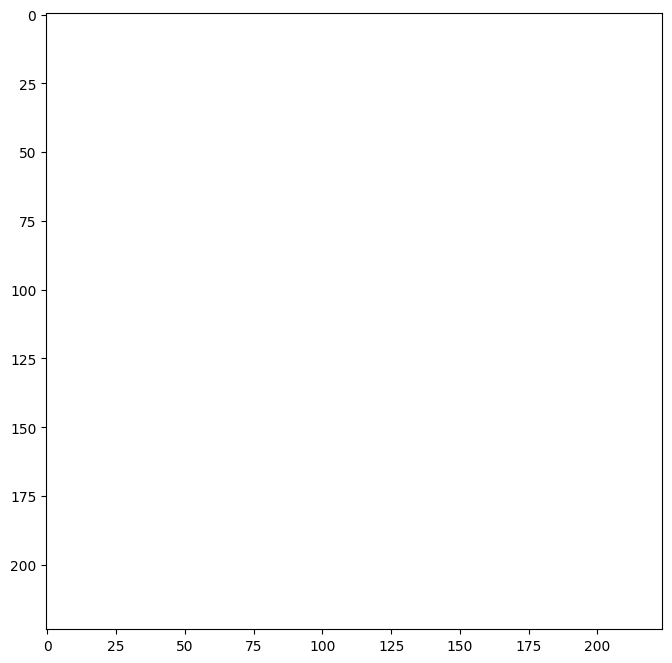

In [211]:
process_all_blocks(image, img_width, img_height, grid, block_len,
                        bg_color, depths,
                        img_points_xy, lookat_var, conic_opacity, results, num_gaussians,
                        tiles_touched)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

a=0


In [212]:
import cv2 as cv
image_uint8 = np.array(image * 255.0, dtype=np.uint8)


image_bgr = cv.cvtColor(image_uint8, cv.COLOR_RGB2BGR)


cv.imshow("image", image_bgr)
cv.waitKey(0)
cv.destroyAllWindows()

In [213]:
print(image[100:110,100:110])

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.

In [214]:
import numpy as np
a = np.array([[1,0,0],[0,2,0],[0,0,3]])
b = np.array([[6,6,6],[1,2,1]])
c=(2,3)
print(c[0])



2


In [215]:
# Define a dictionary with tuple keys
data = {
    (3, 5): 'a',
    (1, 2): 'b',
    (1, 5): 'c',
    (2, 7): 'd',
    (3, 2): 'e',
    (1, 8): 'f'
}

# Sort the dictionary based on your criteria
# Sort by first value in ascending order, then second value in descending order
sorted_data = dict(sorted(data.items(), key=lambda x: (x[0][0], -x[0][1])))

print(data.keys())
for i in range(1,4,1):
    print(data[list(data.keys())[i]])

for i in range(1,4,1):
    print(list(data.values())[i])
# Print the sorted dictionary
#for k, v in sorted_data.items():
#    print(f"{k}: {v}")

dict_keys([(3, 5), (1, 2), (1, 5), (2, 7), (3, 2), (1, 8)])
b
c
d
b
c
d
